In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
import pandas as pd

data = pd.DataFrame(heart_disease.data.original) 
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


Primeiramente mostrando que o nosso problema de classificação se encaixa num problema multiclasse

In [2]:
data['num'].value_counts()

num
0    164
1     55
2     36
3     35
4     13
Name: count, dtype: int64

5 classes diferentes para cada instância, representando:<br>
    - 0 para nenhuma doença cardíaca<br>
    - 1 a 4 para diferentes doenças cardíacas

Levemente desbalanceadas

# Apenas tratando valores ausentes!!

In [3]:
from sklearn.impute import SimpleImputer
import numpy as np

dtypes = data.dtypes
columns = data.columns # Salvando as colunas da base de dados

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data = imp.fit_transform(data)
data = pd.DataFrame(data, columns=columns)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   sex       303 non-null    float64
 2   cp        303 non-null    float64
 3   trestbps  303 non-null    float64
 4   chol      303 non-null    float64
 5   fbs       303 non-null    float64
 6   restecg   303 non-null    float64
 7   thalach   303 non-null    float64
 8   exang     303 non-null    float64
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    float64
 11  ca        303 non-null    float64
 12  thal      303 non-null    float64
 13  num       303 non-null    float64
dtypes: float64(14)
memory usage: 33.3 KB


# Separando conjunto de treinamento e de teste

In [4]:
from sklearn.model_selection import train_test_split

# data (as pandas dataframes) 
y = data['num']
x = data.drop(columns=['num'])
print(x.head())

x_train, x_test, y_train, y_test = train_test_split(
    x, 
    y, 
    test_size=0.3, 
    random_state=0, 
    shuffle=True, 
    stratify=y
)

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca  thal  
0    3.0  0.0   6.0  
1    2.0  3.0   3.0  
2    2.0  2.0   7.0  
3    3.0  0.0   3.0  
4    1.0  0.0   3.0  


Criando diversos estimadores para comparação, criação de ensembles baseados nesses classificadores

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


# Estimadores base
models = {
    "Tree": DecisionTreeClassifier(random_state=0),
}

# Classificadores baseados em bagging
bagging_models = {}
for model_name, model in models.items():
    model_boosting = BaggingClassifier(model, random_state=0)
    name = f"Bagging{model_name}"
    bagging_models[name] = model_boosting

# Classificadores baseados em boosting
boosting_models = {}
for model_name, model in models.items():
    model_boosting = AdaBoostClassifier(model, random_state=0)
    name = f"AdaBoosting{model_name}"
    boosting_models[name] = model_boosting

# Combinar modelos em único dicionário
combined_models = {**models, **bagging_models, **boosting_models}
combined_models['RandomForest'] = RandomForestClassifier(random_state=0)


In [6]:
x_train['ca'].value_counts()

ca
0.0    125
1.0     45
2.0     27
3.0     15
Name: count, dtype: int64

# Modelos OVO (OneVsOne)

In [7]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import precision_score

# Vetor de avaliação
metrics = []
for model_name, model in combined_models.items():
    model_ovo = OneVsOneClassifier(model).fit(x_train, y_train)

    # Fazer previsões
    y_pred = model_ovo.predict(x_test)
    
    # Calcular as métricas
    # Precision Micro
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    
    # Armazenar os resultados em uma lista
    metrics.append({
        "Modelo": model_name,
        "precision_micro": precision_micro,
        "precision_macro": precision_macro,
        "precision_weighted": precision_weighted
    })

# criando um DataFrame pandas com as métricas
df_metrics = pd.DataFrame(metrics)

print(df_metrics)

/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-

            Modelo  Acurácia  F1 Macro  F1 Weighted
0             Tree  0.428571  0.293113     0.520081
1      BaggingTree  0.571429  0.315100     0.527899
2  AdaBoostingTree  0.527473  0.276751     0.502991
3     RandomForest  0.593407  0.323377     0.508515


Como é notável, nossos modelos não performaram bem no modelo OVO

# Modelos OVA (OneVsAll)

In [8]:
from sklearn.multiclass import OneVsRestClassifier

# Vetor de avaliação
metrics = []
for model_name, model in combined_models.items():
    model_ovo = OneVsRestClassifier(model).fit(x_train, y_train)

    # Fazer previsões
    y_pred = model_ovo.predict(x_test)
    
    # Calcular as métricas
    precision_micro = precision_score(y_test, y_pred, average='micro')
    precision_macro = precision_score(y_test, y_pred, average='macro')
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    
    # Armazenar os resultados em uma lista
    metrics.append({
        "Modelo": model_name,
        "Acurácia": precision_micro,
        "F1 Macro": precision_macro,
        "F1 Weighted": precision_weighted
    })

# criando um DataFrame pandas com as métricas
df_metrics = pd.DataFrame(metrics)

print(df_metrics)

/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-

            Modelo  Acurácia  F1 Macro  F1 Weighted
0             Tree  0.373626  0.300040     0.515755
1      BaggingTree  0.593407  0.324011     0.537487
2  AdaBoostingTree  0.362637  0.294105     0.507355
3     RandomForest  0.549451  0.238235     0.430780


/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dani/ciencias-da-computacao/8-semestre/mineracao-de-dados/atividade-1/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

models_tree = GridSearchCV(
    models['Tree'], 
    param_grid={"criterion": ["entropy", "gini", "log_loss"], "max_depth": [3, 6, 9]},
    scoring=make_scorer(precision_score, average="micro"),
    cv=3,
    refit=True
)
# Ajustar o GridSearchCV com seus dados
models_tree.fit(x_train, y_train)  # Substitua X e y pelos seus dados

# Agora você pode acessar o melhor estimador
best_tree = models_tree.best_estimator_

print(models_tree.best_estimator_)

DecisionTreeClassifier(max_depth=3, random_state=0)


In [15]:
df = pd.DataFrame(best_tree.cv_results_)[['params','rank_test_score','mean_test_score']]
df

,params,rank_test_score,mean_test_score
0,"{'criterion': 'entropy', 'max_depth': 3}",2,0.514152
1,"{'criterion': 'entropy', 'max_depth': 6}",6,0.462240
2,"{'criterion': 'entropy', 'max_depth': 9}",8,0.457411
3,"{'criterion': 'gini', 'max_depth': 3}",1,0.523407
4,"{'criterion': 'gini', 'max_depth': 6}",5,0.476258
5,"{'criterion': 'gini', 'max_depth': 9}",4,0.490476
6,"{'criterion': 'log_loss', 'max_depth': 3}",2,0.514152
7,"{'criterion': 'log_loss', 'max_depth': 6}",6,0.462240
8,"{'criterion': 'log_loss', 'max_depth': 9}",8,0.457411


Como visto acima, as árvores mais rasas tendem a uma melhora nas medidas multiclassse justamente porque as árvores mais profundas tendem overfitting

# BestTree em OVO

In [16]:
model = OneVsOneClassifier(best_tree).fit(x_train, y_train)
y_pred = model.predict(x_test)

precision_micro = precision_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')

print(precision_micro, precision_macro)

0.5494505494505495 0.3322077922077922


# BestTree em OVA

In [17]:
model = OneVsRestClassifier(best_tree).fit(x_train, y_train)
y_pred = model.predict(x_test)

precision_micro = precision_score(y_test, y_pred, average='micro')
precision_macro = precision_score(y_test, y_pred, average='macro')

print(precision_micro, precision_macro)

0.5934065934065934 0.3322366522366523


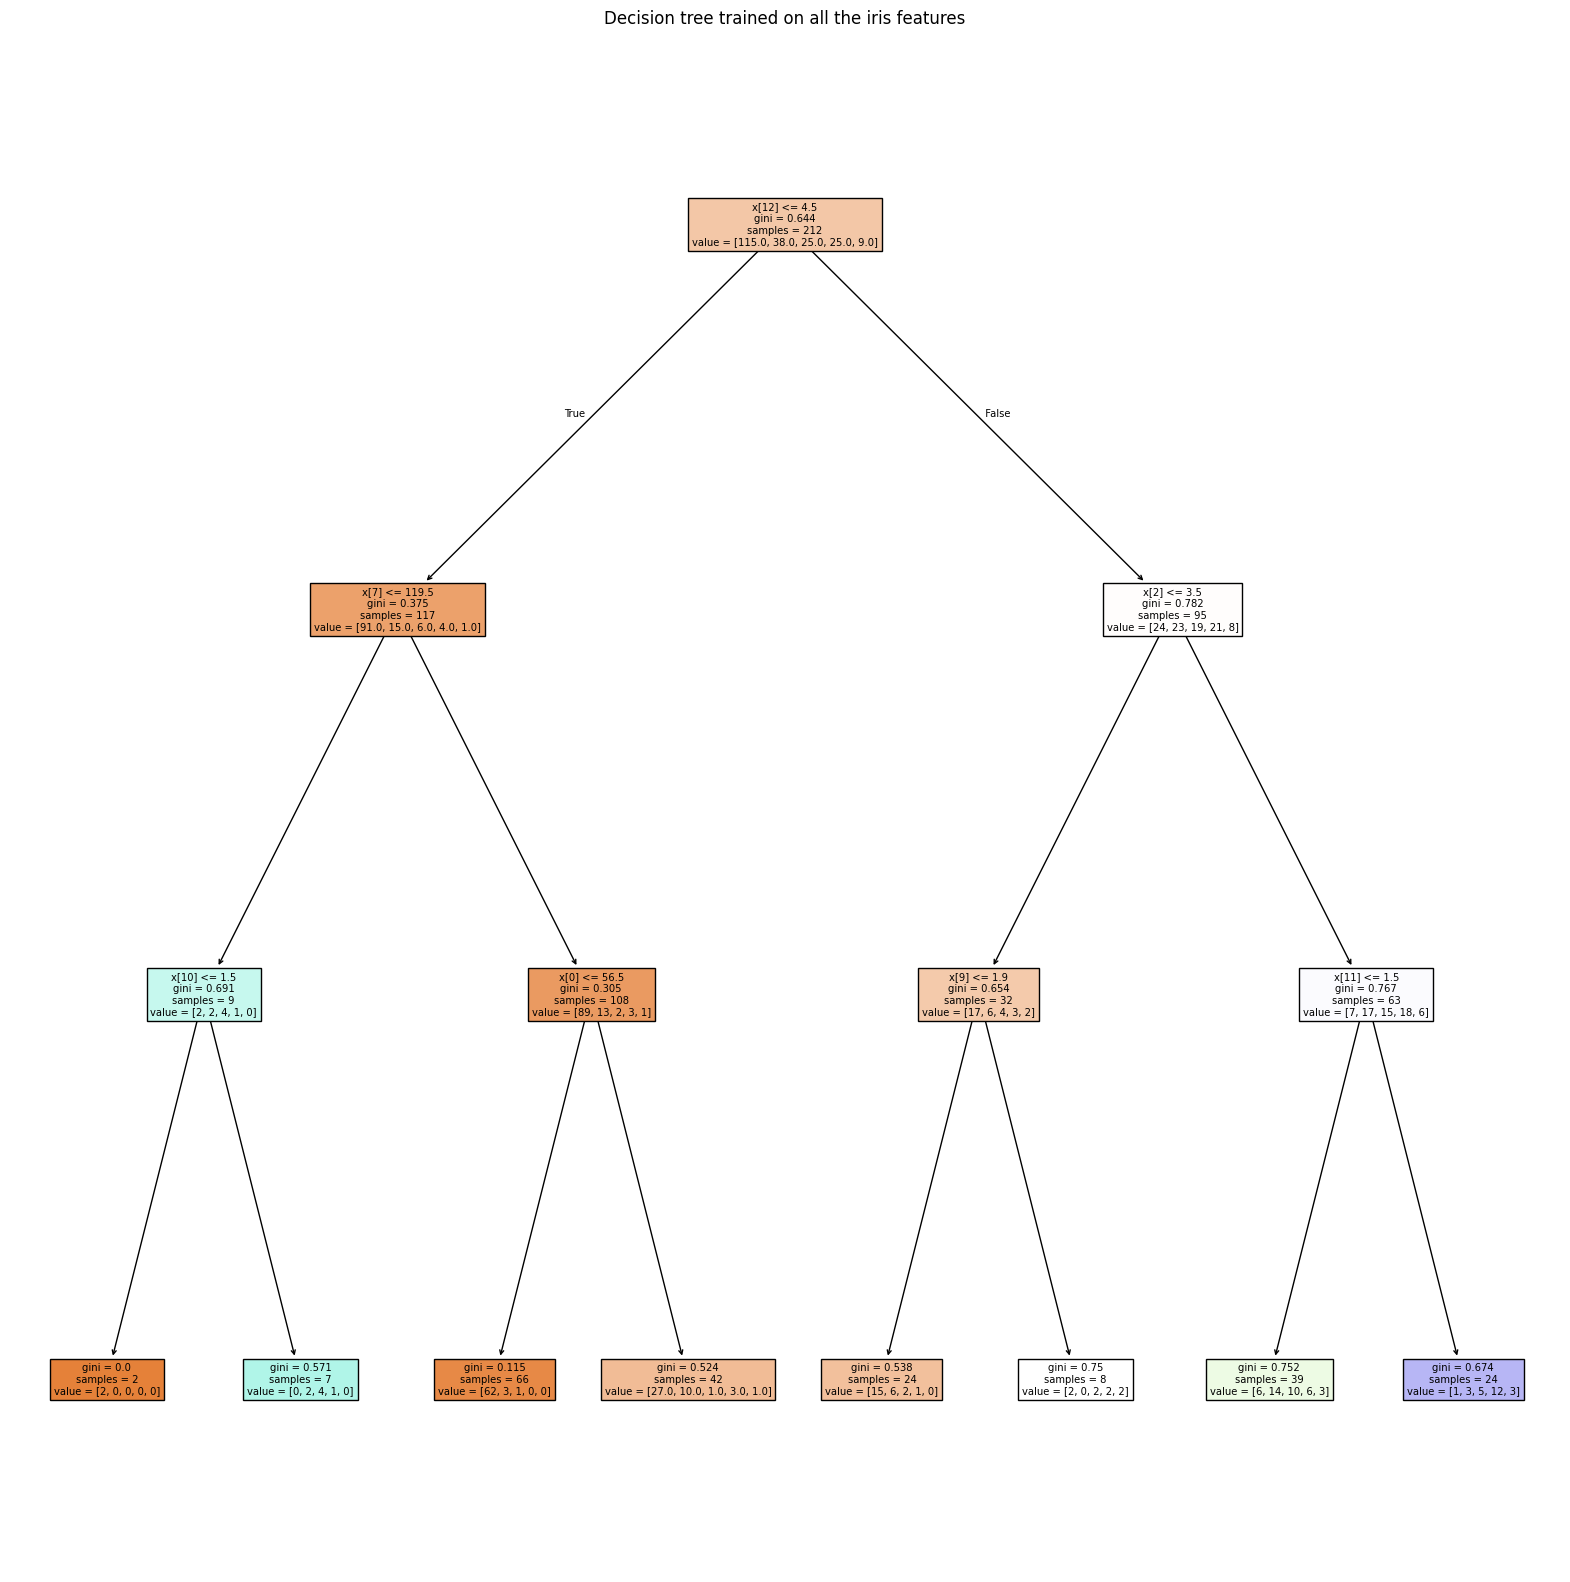

In [23]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
best_tree_trained = best_tree.fit(x_train, y_train)
plt.figure()
plt.rcParams["figure.figsize"] = (20,20)
plot_tree(best_tree_trained, filled=True)
plt.title("Decision tree trained on all the iris features")
plt.show()